In [1]:
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval
except Exception:
    pass

In [2]:
# You will need matplotlib for visualing our dataset and
# numpy to be able to handle the data.
import matplotlib.pyplot as plt
import numpy as np

# Load the classes from DataEval that are helpful for EDA
from dataeval.detectors.linters import Duplicates, Outliers
from dataeval.metrics.stats import hashstats, labelstats
from dataeval.utils.datasets import VOCDetection

# Set the random value
rng = np.random.default_rng(213)

In [3]:
# Helper method to plot images of interest
def plot_sample_images(
    dataset, outlier_class, outlier_result, metric: str, metric_dict: dict[str, list[int]], layout: tuple[int, int]
) -> None:
    _, axs = plt.subplots(*layout, figsize=(10, layout[0] * 4))
    selected_index = rng.choice(metric_dict[metric], min(int(np.prod(layout)), len(metric_dict[metric])), replace=False)

    for i, ax in enumerate(axs.flat):
        ax.imshow(dataset[selected_index[i]][0].transpose(1, 2, 0))
        ax.set_title(f"{metric}={np.round(outlier_result.issues[selected_index[i]][metric], 2)}")
        ax.axis("off")

    print(f"metric={metric}")
    print(f"quantiles={np.round(np.quantile(outlier_class.stats.data()[metric], [0, 0.25, 0.5, 0.75, 1]), 2)}")
    plt.tight_layout()
    plt.show()

In [4]:
# Download the data and then load it as a torch Tensor
ds = VOCDetection("./data", image_set="train", year="2011", download=True)
print(ds)

VOCDetection Dataset
--------------------
    Year: 2011
    Transforms: []
    Image_set: train
    Metadata: {'id': 'VOCDetection_train', 'index2label': {0: 'aeroplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle', 5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person', 15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'tvmonitor'}, 'split': 'train'}
    Path: /dataeval/docs/source/notebooks/data/vocdataset/TrainVal/VOCdevkit/VOC2011
    Size: 5717


In [5]:
# Calculate basic label statistics from the dataset
lstats = labelstats(ds)

# Display label stats
print(lstats.to_table())

Class Count: 20
Label Count: 15774
Average # Labels per Image: 2.76
--------------------------------------
      Label: Total Count - Image Count
  aeroplane:     470     -     328
    bicycle:     410     -     281
       bird:     592     -     399
       boat:     508     -     264
     bottle:     749     -     399
        bus:     317     -     219
        car:    1191     -     621
        cat:     609     -     540
      chair:    1457     -     656
        cow:     355     -     155
diningtable:     373     -     318
        dog:     768     -     636
      horse:     377     -     238
  motorbike:     375     -     274
     person:    5019     -    2142
pottedplant:     557     -     289
      sheep:     509     -     171
       sofa:     399     -     359
      train:     327     -     275
  tvmonitor:     412     -     299


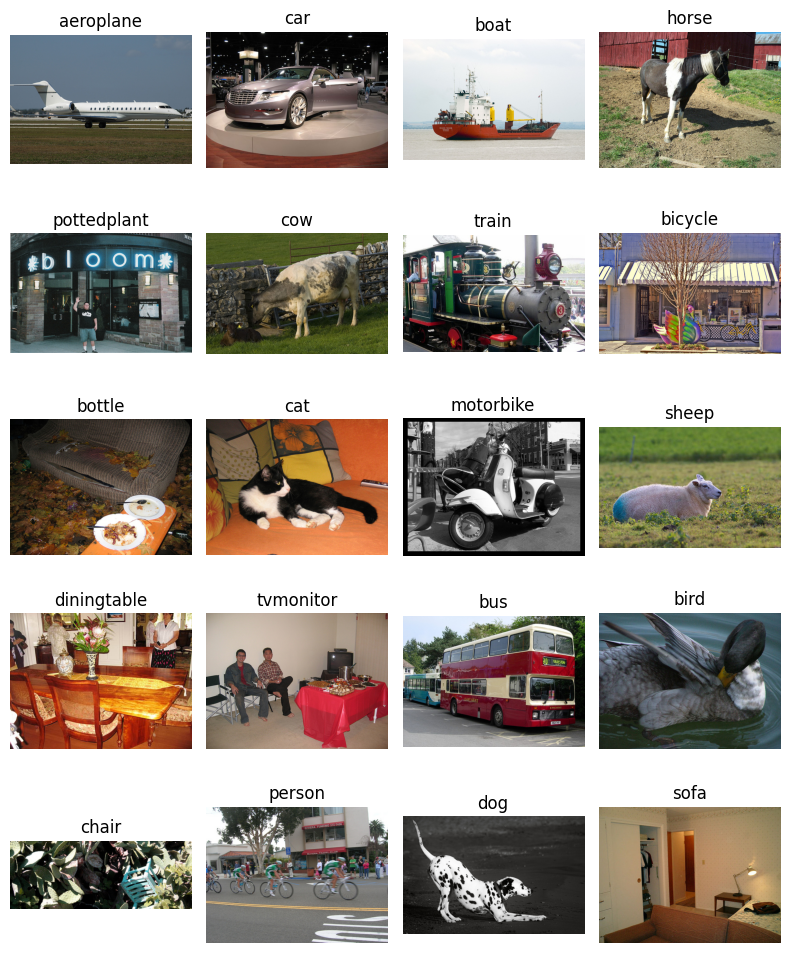

In [6]:
# Plot random images from each category
_, axs = plt.subplots(5, 4, figsize=(8, 10))

for ax, (category, indices) in zip(axs.flat, lstats.image_indices_per_class.items()):
    # Randomly select an index from the list of indices
    ax.imshow(ds[rng.choice(indices)][0].transpose(1, 2, 0))
    ax.set_title(lstats.class_names[category])
    ax.axis("off")

plt.tight_layout()
plt.show()

In [7]:
# This cell takes about 1-5 minutes to run depending on your hardware

# Initialize the Outliers class
outliers = Outliers(outlier_method="zscore")

# Find the extreme images
outlier_imgs = outliers.evaluate(ds)

# View the number of extreme images
print(f"Number of images with extreme values: {len(outlier_imgs)}")

  0%|          | 0/5717 [00:00<?, ?it/s]

Number of images with extreme values: 480


In [8]:
# List the metrics with an extreme value
metrics = {}
for img, group in outlier_imgs.issues.items():
    for extreme in group:
        if extreme in metrics:
            metrics[extreme].append(img)
        else:
            metrics[extreme] = [img]
print(f"Number of metrics with extremes: {len(metrics)}")

# Show the total number of extreme values for each metric
for group, imgs in sorted(metrics.items(), key=lambda item: len(item[1]), reverse=True):
    print(f"  {group} - {len(imgs)}")

Number of metrics with extremes: 15
  size - 173
  entropy - 123
  contrast - 92
  skew - 89
  zeros - 77
  kurtosis - 73
  brightness - 52
  width - 43
  var - 35
  aspect_ratio - 33
  mean - 29
  std - 22
  height - 22
  darkness - 20
  sharpness - 2


In [9]:
# Display the table
print(outlier_imgs.to_table(lstats))

        Class |  aspect_ratio  |  brightness  |  contrast  |  darkness  |  entropy  |  height  |  kurtosis  |  mean   |  sharpness  |  size   |  skew   |   std   |   var   |  width  |  zeros  | Total                                                                                                                                                                          
    aeroplane |       7        |      22      |     4      |     2      |    28     |    5     |     23     |    7    |      0      |   12    |   30    |    6    |    1    |    1    |    1    |                                                                                       149                                                                                      
      bicycle |       0        |      1       |     3      |     0      |     3     |    0     |     2      |    1    |      0      |   10    |    3    |    0    |    0    |    5    |    2    |                                                                   

metric=entropy
quantiles=[0.28 5.05 5.23 5.36 5.53]


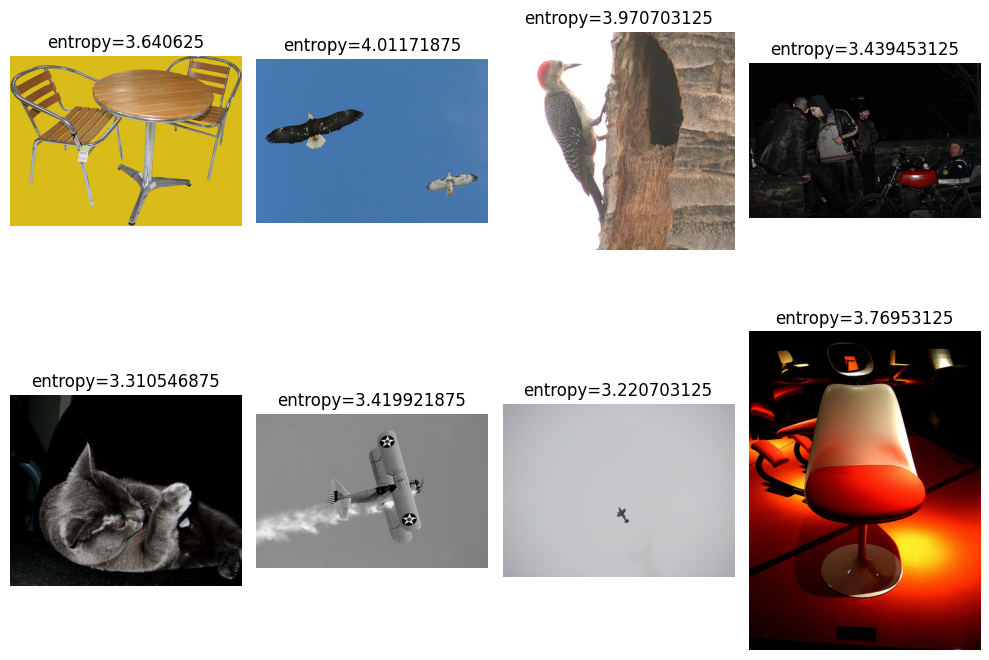

In [10]:
# Plot images flagged for "entropy"
plot_sample_images(ds, outliers, outlier_imgs, "entropy", metrics, (2, 4))

metric=size
quantiles=[ 41250. 166500. 187500. 187500. 250000.]


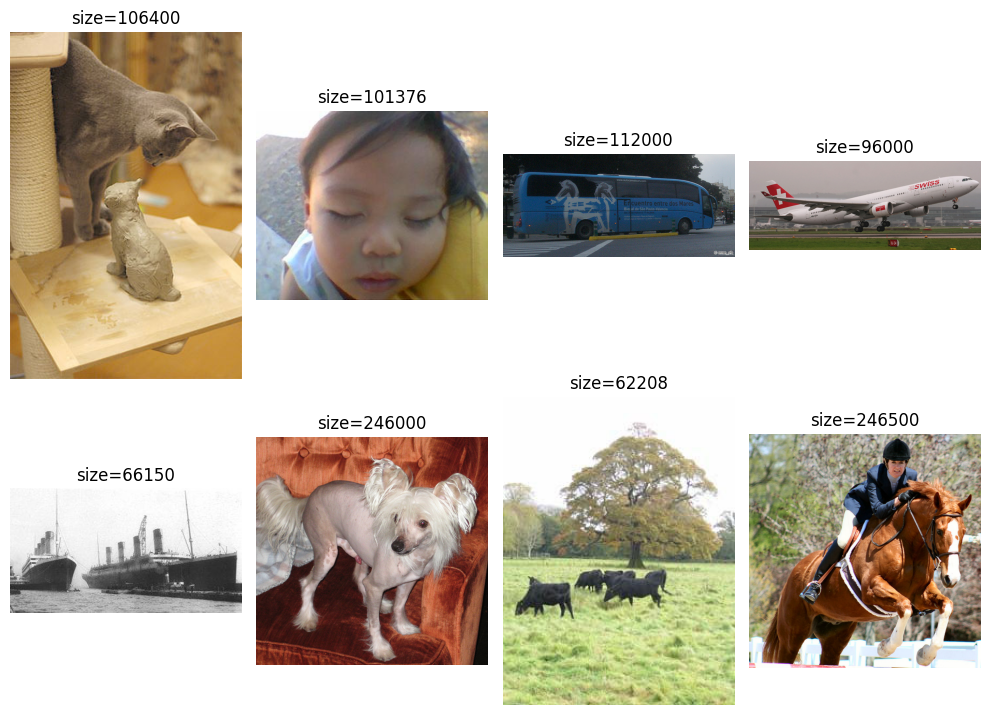

In [11]:
# Plot images flagged for "size"
plot_sample_images(ds, outliers, outlier_imgs, "size", metrics, (2, 4))

metric=zeros
quantiles=[0.   0.   0.   0.   0.71]


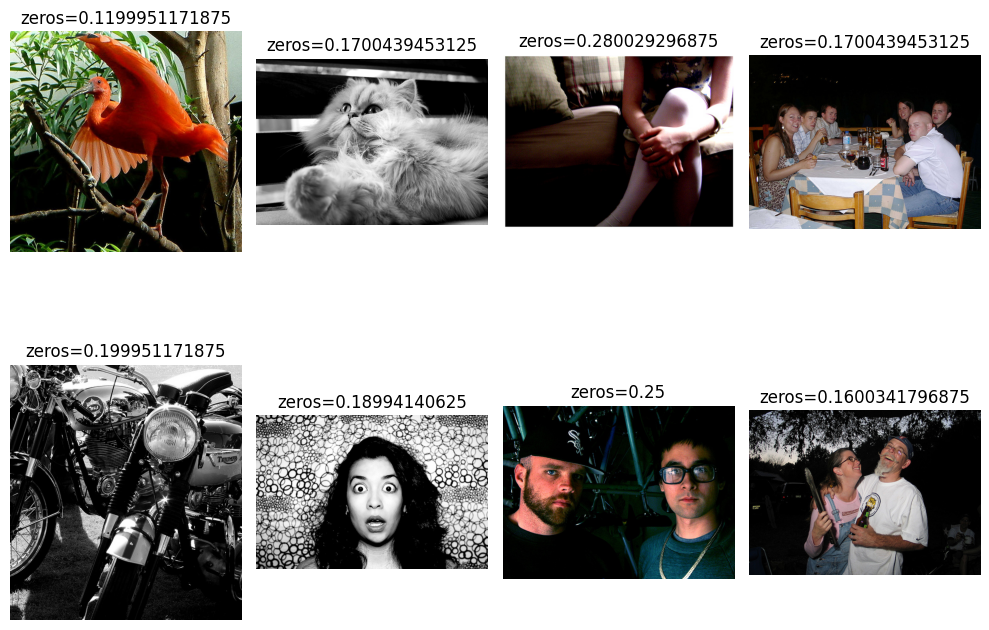

In [12]:
# Plot images flagged for "zeros"
plot_sample_images(ds, outliers, outlier_imgs, "zeros", metrics, (2, 4))

metric=sharpness
quantiles=[  6.11  39.66  52.41  64.94 107.38]


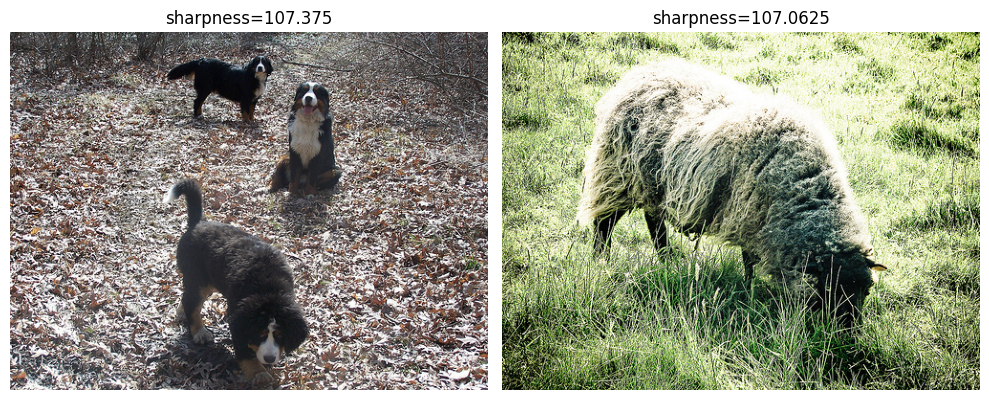

In [13]:
# Plot images flagged for "sharpness"
plot_sample_images(ds, outliers, outlier_imgs, "sharpness", metrics, (1, 2))

In [14]:
# Initialize the Duplicates class
dups = Duplicates()

# Find the duplicates
dups.evaluate(ds)

  0%|          | 0/5717 [00:00<?, ?it/s]

DuplicatesOutput(exact=[], near=[])

In [15]:
# Create exact and duplicate images

# Copy images 23 and 46 to create exact duplicates
# Copy and crop images 5 and 4376 to create near duplicates
dupes = [
    ds[23][0],
    ds[46][0],
    ds[5][0][:, 5:-5, 5:-5],
    ds[4376][0][:, :-5, 5:],
]

dupes_stats = hashstats(dupes)

  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
# Find the duplicates appended to the dataset
duplicates = dups.from_stats([dups.stats, dupes_stats])
print(f"exact: {duplicates.exact}")
print(f"near: {duplicates.near}")

exact: [{0: [23], 1: [0]}, {0: [46], 1: [1]}]
near: [{0: [5], 1: [2]}, {0: [4376], 1: [3]}]
